In [22]:
import torch
from torch import nn
import torch.nn.functional as F

import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

from tqdm import tqdm #For progress bar
import numpy as np

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"./data/MNIST/recons/output{epoch}.jpg")

# Variational Autoencoder for MNIST data
#### A simple convolutional based variational autoencoder for the MNIST data set

In [23]:
#The base class
class Vae(nn.Module):
    '''
    Base class for defining a variational autoencoder
    '''
    def __init__(self, recon_loss_wgt, kld_loss_wgt, loss: str = 'BCE'):
        super().__init__()
        self.set_criterion(loss)
        self.set_loss_weights(recon_loss_wgt, kld_loss_wgt)

    def set_loss_weights(self, recon_loss_wgt, kld_loss_wgt):
        '''
        Set's the balance between the reconstruction loss and the KL-Divergence
        :param recon_loss_weight: weight for the reconstruction loss
        :param kl_div_loss_weight: weight for the KL-Divergence. I have found
          that 1e-4 demonstrated good results for a simple model on mnist data
          while using BCE for reconstruction loss.
        '''
        sum = recon_loss_wgt + kld_loss_wgt
        if sum<= 0.0 or recon_loss_wgt < 0.0 or kld_loss_wgt < 0.0:
            raise ValueError("recon_loss_wgt and kld_loss_wgt must each be >=0 with sum >0")

        self.recon_loss_wgt = recon_loss_wgt / (sum + 1e-8)
        self.kld_loss_wgt = kld_loss_wgt / (sum + 1e-8)

    
    def set_criterion(self, loss: str):
        if loss=='BCE' or loss=='bce':
            self.criterion = nn.BCELoss()
        elif loss=='MSE' or loss=='mse':
            self.criterion = nn.MSELoss()
        else:
            loss = nn.L1Loss()
        

    def final_loss(self, recon_loss, mu, lv):
        """
        This function will form a weighted averag of the reconstruction loss (e.g. BCELoss) and the 
        KL-Divergence.
        :param recon_loss: recontruction loss
        :param mu: the mean from the latent vector
        :param lv: log variance from the latent vector
        """
        kl_divergence = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        return recon_loss * self.recon_loss_wgt + kl_divergence * self.kld_loss_wgt
    
    @staticmethod
    def reparam(mu, lv):
        """
        This function will reparameterize the latent vector
        :param mu: the mean from the latent vector
        :param lv: log variance from the latent vector
        """
        std = torch.exp(0.5*lv)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def train_one_epoch(self, dataloader, dataset, device, optimizer):
        self.train()
        running_loss = 0.0
        counter = 0
        num_batches = int(len(dataset)/dataloader.batch_size)
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            data = data[0].to(device)
            recon, mu, lv = self(data)
            recon_loss = self.criterion(recon, data)
            loss = self.final_loss(recon_loss, mu, lv)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
        train_loss = running_loss / counter 
        return train_loss
    
    def validate(self, dataloader, dataset, device):
        self.eval()
        running_loss = 0.0
        counter = 0
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
                counter += 1
                data= data[0].to(device)
                recon, mu, lv = self(data)
                recon_loss = self.criterion(recon, data)
                loss = self.final_loss(recon_loss, mu, lv)
                running_loss += loss.item()
            
                # save the last batch input and output of every epoch
                if i == int(len(dataset)/dataloader.batch_size) - 1:
                    recon_images = recon
        
        val_loss = running_loss / counter
        return val_loss, recon_images


In [56]:
#The convolutional class
class VaeCnn(Vae):
    def __init__(self, in_dims_HWC: tuple,
                       init_channels: int=8,
                       latent_dim: int=2, 
                       kernel_size: int=3, 
                       recon_loss_wgt: float=0.9999, 
                       kld_loss_wgt: float=1e-4,
                       loss: str= 'BCE'):
        super().__init__(recon_loss_wgt=recon_loss_wgt, kld_loss_wgt=kld_loss_wgt, loss=loss)
        '''
        in_dims_HWC:    the dimension (HxW) and the number of channels in the input image data 
        init_channels:  the number of channels in the first conv layer
        latent_dim:     the dimension of the latent vector (z)
        kernel_size:    the kernel size for each of the conv layers
        recon_loss_wgt: the weight to place on the reconstruction loss
        kld_loss_wgt:   the weight to place on the KL-Divergence loss
        loss:           the loss function to use for the reconstruction loss

        Notes:
        - if loss in other than BCE, MSE will be used.
        - the recon loss wieght is relative to BCE loss function. This may need to change with MSE or L1
        - MSE and L1 should be explored as loss function options
        '''

        self.in_dims = in_dims_HWC
        down_layers = 1 #the number of downsampling layers

        enc_block = (init_channels*2, self.get_input_height()//2, self.get_input_width()//2) #The size of the last encoded block
        enc_features = enc_block[0]*enc_block[1]*enc_block[2] #The size of the flattened encoded block

        # encoder   
        self.encoder = nn.Sequential(
            nn.Conv2d(self.get_input_channels(), init_channels, kernel_size=kernel_size, padding='same'), #N,C,H,W
            nn.ReLU(),
            nn.Conv2d(init_channels, init_channels*2, kernel_size=kernel_size, padding=1, stride=2), #N,2*C,H/2,W/2
            nn.ReLU(), 
            nn.Conv2d(init_channels*2, init_channels*2, kernel_size=kernel_size, padding='same'), #N,2*C,14,14
            nn.ReLU(),
            nn.Conv2d(init_channels*2, init_channels*2, kernel_size=kernel_size, padding='same', stride=1), #N,2XC,14,14
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(enc_features, 32),
            nn.ReLU()
        )

        # fully connected layers for learning representations
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_lv = nn.Linear(32, latent_dim)

        # Reparam next in the forward

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, enc_features),
            nn.ReLU(),
            nn.Unflatten(1, enc_block),
            nn.Conv2d(init_channels*2, 32, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, self.get_input_channels(), kernel_size=kernel_size, padding='same'),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        # encoder
        encoded = self.encoder(x)
        
        #the reparametrization to learn mu and (log) variance
        mu = self.fc_mu(encoded)
        lv = self.fc_lv(encoded)
        z = self.reparam(mu, lv)
            
        # decoder
        recon = self.decoder(z)
        return recon, mu, lv

    '''
    Extraction and explanation of input diensions
    '''
    def get_input_channels(self):
        return self.in_dims[2]

    def get_input_height(self):
        return self.in_dims[0]
    
    def get_input_width(self):
        return self.in_dims[1]

In [25]:
#Data loading
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor() 
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

In [26]:
#Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_channels = 1
image_height = 28
image_width = 28
input_dimens = (image_height, image_width, image_channels)
init_channels = 8
latent_dim = 2
recon_wgt = 0.9999
kl_wgt = 1 - recon_wgt
loss = 'BCE'

loss_fn = nn.MSELoss()

model = VaeCnn( in_dims_HWC=input_dimens, 
                init_channels=init_channels,
                latent_dim=latent_dim,
                kernel_size=3,
                loss = loss,
                kld_loss_wgt = kl_wgt,
                recon_loss_wgt = recon_wgt).to(device)

lr=1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

grid_images = [] #sample of created images

train_loss = []
valid_loss = []


In [ ]:
#training loop
lr = 3e-5
optimizer.learning_rate = lr
model.set_criterion(loss_fn)
kl_wgt = 5e-2#1e-4
recon_wgt = 1.0 - kl_wgt
#model.set_loss_weights( recon_loss_wgh=recon_wgt, kld_loss_wgt=kl_wgt)
num_epochs = 263
prev_epochs = 137

for epoch in range(num_epochs):
    cur_epoch = epoch + prev_epochs + 1
    print(f"Epoch {cur_epoch} / {num_epochs+prev_epochs}")
    train_epoch_loss = model.train_one_epoch(
        train_loader, trainset, device, optimizer
    )
    
    #Update the learning rate
    #if(cur_epoch == 5):
     #   optimizer.learning_rate = 1e-4
    if (cur_epoch) % 10 == 0:
        optimizer.learning_rate *= 0.5

    valid_epoch_loss, recon_images = model.validate(
        test_loader, testset, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, cur_epoch)
    # save the model weights
    #torch.save(model.state_dict(), f"./data/MNIST/model/model2_weights_epoch_{cur_epoch}.pth") 
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")


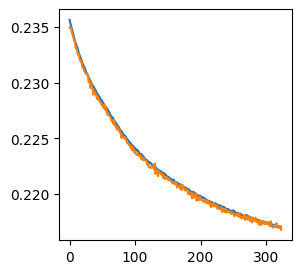

374


In [105]:
beg=50
plt.figure(figsize=(3,3))
plt.plot(train_loss[beg:])
plt.plot(valid_loss[beg:])
plt.show()

print(len(train_loss))

In [106]:
#Check the cu and variance stats
mu1=[]
mu2=[]
lv1=[]
lv2=[]

y_train=[]
for data, label in train_loader:
  data = data.to(device)
  #print(label.shape)
  img,mu,lv = model(data)
  mu = mu.cpu().detach().numpy()
  lv = lv.cpu().detach()
  for k in range(mu.shape[0]):
    mu1.append(mu[k,0])
    mu2.append(mu[k,1])
    lv1.append(lv[k,0])
    lv2.append(lv[k,1])
    y_train.append(label[k])

mu1 = np.asarray(mu1)
mu2 = np.asarray(mu2)
lv1 = np.asarray(lv1)
lv2 = np.asarray(lv2)


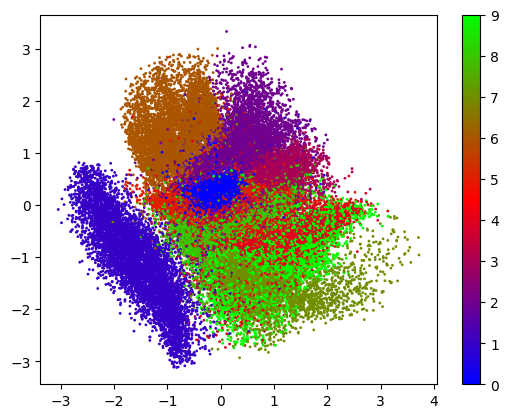

In [110]:
plt.scatter(mu1,mu2,s = 1, c=y_train,cmap='brg')
plt.colorbar()
plt.show()

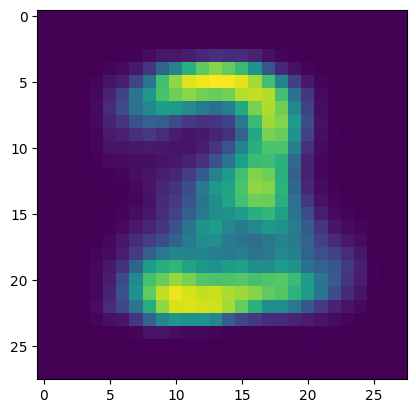

In [102]:
latent_code = np.asarray([.8,1.], dtype=np.float32)
latent_code = torch.tensor(latent_code).unsqueeze(0).to(device)
img = model.decoder(latent_code)
img = img.detach()[0][0]

plt.imshow(img)


In [109]:
chkpt_dict = {
  'epoch': 374,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss function': 'BCELoss',
  'loss': 0.2170,
  'val_loss': 0.2168,
  'kl_weight': 0.0001,
  'comments': 'Best luck with smaller kl_weight using BCE reconstruciton loss. Did not explore either MSE or L1 reconstruction loss.'
}

chkpt_path = './data/MNIST/model/MNIST_Vae_Cnn.pth'

torch.save(chkpt_dict, chkpt_path)

In [1]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
